## Pricing Asian Style Options
In this script we show how to use classes in *QMCPy* for Monte Carlo option pricing of options with Asian style payoffs and European exercise.

- The payoff depends on the whole asset price path, not only on the terminal asset price.
- The option is only exercised at expiry, unlike American options, which can be exercised at any time before expiry.


In [1]:
# Import necessary packages
import qmcpy as qp
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import time

### Option Parameters
Below we set differnt parameters for the stock price and the option.

In [2]:
initPrice = 120 # initial stock price
interest = 0.02 # risk-free interest rate
vol = 0.5 # volatility
callput = 'call' # call options
strike = 130 # strike price
tfinal = 1/4 # mature time
d = 12 # number of observations in time
absTol = 0.05 # absolute tolerance of a nickel
relTol = 0 # zero relative tolerance
sampleSize = 10**6 # number of smaple size
meanType = 'arithmetic'

### Arithmetic Mean Options
The payoff of the arithmetic mean option depends on the average of the
stock price, not the final stock price.  Here are the discounted payoffs:

$$\begin{array}{rcc}
 & \textbf{call} & \textbf{put} \\ \hline
\textbf{payoff} &
\displaystyle \max\biggl(\frac 1d \sum_{j=1}^d S(jT/d) - K,0 \biggr)\mathsf{e}^{-rT} &
\displaystyle \max\biggl(K - \frac 1d \sum_{j=1}^d S(jT/d),0 \biggr)\mathsf{e}^{-rT}
\end{array}
$$

First we set up the integrand that represents the Airthmetic Mean Call
We need to choose the type of points

In [3]:
SobolPoints = qp.Sobol(dimension =  d)  #These are Sobol' points
IIDPoints = qp.IIDStdUniform(dimension=d)  #These are IID points
HaltonPoints = qp.Halton(dimension=d)  #These are Halton' points
LatticePoints= qp.Lattice(dimension=d)  #These are lattice points

Then we set up the integrand with the sample points

In [4]:
ArithMeanCallSobol = qp.AsianOption(SobolPoints, volatility= vol,start_price= initPrice, strike_price=strike, interest_rate = interest,t_final=1/4,call_put=callput,mean_type=meanType)
ArithMeanCallIID = qp.AsianOption(IIDPoints, volatility= vol,start_price= initPrice, strike_price=strike, interest_rate = interest,t_final=1/4,call_put=callput,mean_type=meanType)
ArithMeanCallHalton = qp.AsianOption(HaltonPoints, volatility= vol,start_price= initPrice, strike_price=strike, interest_rate = interest,t_final=1/4,call_put=callput,mean_type=meanType)
ArithMeanCallLattice = qp.AsianOption(LatticePoints, volatility= vol,start_price= initPrice, strike_price=strike, interest_rate = interest,t_final=1/4,call_put=callput,mean_type=meanType)

Then we use the stopping criterion to get the price of the option to the desired tolerance

In [5]:
tol_vec = np.array([0.5, 0.1, 0.05, 0.01, 0.005])  #an array of tolerances
nSobol_required = np.zeros_like(tol_vec)
tSobol_required = np.zeros_like(tol_vec)
nIID_required = np.zeros_like(tol_vec)
tIID_required = np.zeros_like(tol_vec)
nHalton_required = np.zeros_like(tol_vec)
tHalton_required = np.zeros_like(tol_vec)
nLattice_required = np.zeros_like(tol_vec)
tLattice_required = np.zeros_like(tol_vec)
for ii, abs_tol in enumerate(tol_vec):
    print(ii)
    SobolArithMeanCallPrice, data = qp.CubQMCSobolG(ArithMeanCallSobol,abs_tol = abs_tol).integrate()
    nSobol_required[ii] = data.n_total
    tSobol_required[ii] = data.time_integrate
    HaltonArithMeanCallPrice, data = qp.CubQMCCLT(ArithMeanCallHalton,abs_tol = abs_tol).integrate()
    nHalton_required[ii] = data.n_total
    tHalton_required[ii] = data.time_integrate
    LatticeArithMeanCallPrice, data = qp.CubQMCLatticeG(ArithMeanCallLattice,abs_tol = abs_tol).integrate()
    nLattice_required[ii] = data.n_total
    tLattice_required[ii] = data.time_integrate
    # IIDArithMeanCallPrice, data = qp.CubMCG(ArithMeanCallIID,abs_tol = abs_tol).integrate()
    # nIID_required[ii] = data.n_total
    # tIID_required[ii] = data.time_integrate
print("price =", SobolArithMeanCallPrice, "# Sobol points =", nSobol_required)
# print("price =", IIDArithMeanCallPrice, "# IID points =", nIID_required)
print("price =", HaltonArithMeanCallPrice, "# Halton points =", nHalton_required)
print("price =", LatticeArithMeanCallPrice, "# Lattice points =", nLattice_required)

0
1
2
3
4
price = [3.38821577] # Sobol points = [1024. 1024. 1024. 4096. 8192.]
price = [3.38926404] # Halton points = [  4096.   4096.  16384.  65536. 131072.]
price = [3.38977297] # Lattice points = [1024. 1024. 1024. 8192. 8192.]


### Plotting the results

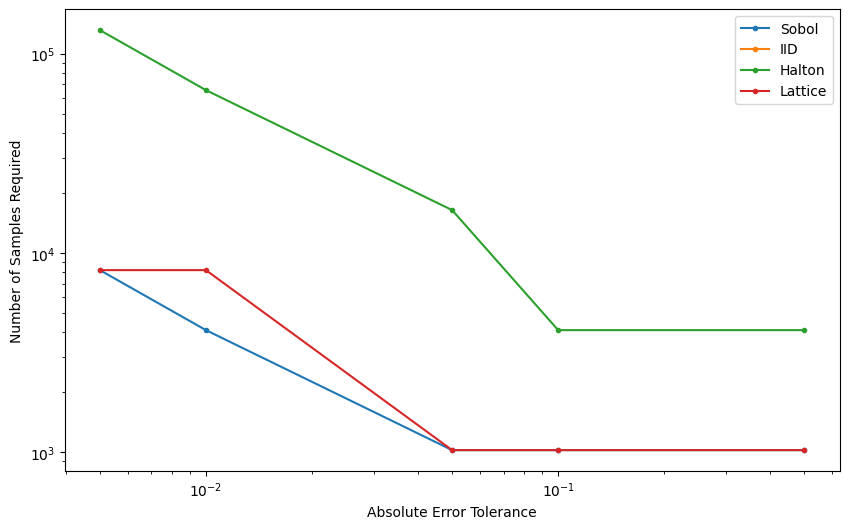

In [6]:
plt.figure(figsize=(10, 6))
plt.loglog(tol_vec,nSobol_required,'.-',label = 'Sobol')
plt.loglog(tol_vec,nIID_required,'.-',label = 'IID')
plt.loglog(tol_vec,nHalton_required,'.-',label = 'Halton')
plt.loglog(tol_vec,nLattice_required,'.-',label = 'Lattice')
plt.xlabel('Absolute Error Tolerance')
plt.ylabel('Number of Samples Required')
plt.legend()
plt.show()

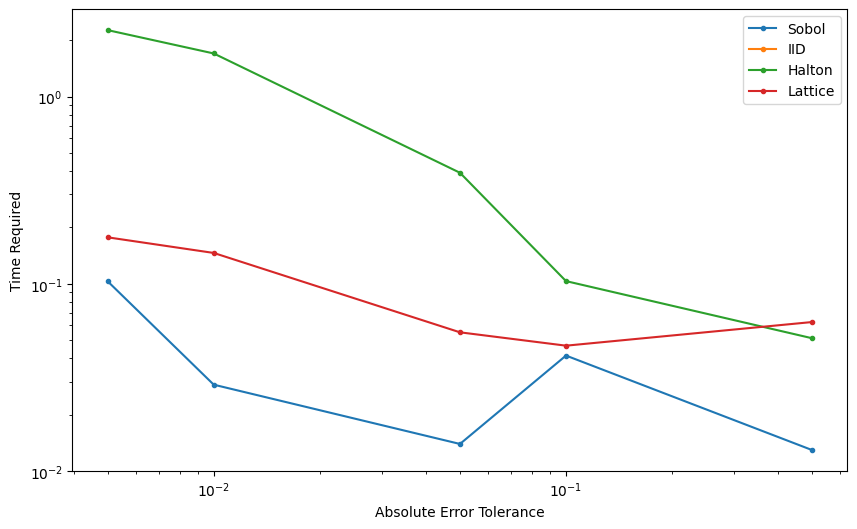

In [7]:
plt.figure(figsize=(10, 6))
plt.loglog(tol_vec,tSobol_required,'.-',label = 'Sobol')
plt.loglog(tol_vec,tIID_required,'.-',label = 'IID')
plt.loglog(tol_vec,tHalton_required,'.-',label = 'Halton')
plt.loglog(tol_vec,tLattice_required,'.-',label = 'Lattice')
plt.xlabel('Absolute Error Tolerance')
plt.ylabel('Time Required')
plt.legend()
plt.show()